## LEARNING HUMAN DRIVING BEHAVIOUR USING DEEP NEURAL NETWORKS AND IMPROVISING WITH DATA AUGMENTATION AND FILTERING



The main Objective of this project is to build an network that can analyse human driving pattern and mmimic the same in generalised situations. The idea was to get training data from track1, augment it and feed it to a neural network with steering angles as the labels for each image captured during recording. I used keyboard and mouse as my main means of movement. 

One thing I was quite sure of, while doing this project is that validating the network is not a necessary task as the validation sets with comparibly higher loss were somtimes able to perform well than the others. This leads me to test all the models generated to test. The decision criteria was, if the model was not able to complete atleast one full lap in track1 with out any jerks or running away from tracks that model is considered to be part of result models set. 

### Python code for this project is broken to parts as listed below
1. Data acquisition and visualization from storage space 
2. Augmenting image data
  * Applying CLAHE to the image data set to equalize the contrast.
  * Cropping the image and rescaling it to the required proportional size.
  * Randomly applying shadows on a portion of the image.
  * Randomly shift the image up and down.
  * Including left and right camera images to the train data set by adding offset to the steering angle and performing the above     techinques on those images.
  * Applying gamma correction to the images.
  * Shearing and rotating a sub-sample of data
  * Horizontally flipping images and negating the steering angles.
  * Randomly subsampling over the train data.
3. Creating a neural network model that optimises over the train data set collected.
4. Creating an object that keeps track of weights at the end of each epoch and training the network.
5. Choosing the right model weights by testing it on track1.
6. Finally testing the choosen model to work on a generalised track that is Track2.

#### Step1 : Data acquisition

In [2]:
# Importing required python packages 
import numpy as np
import tensorflow as tf
import h5py
import os
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math 
import random
import skimage
from numpy.random import random
from keras import models, optimizers, backend
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
tf.python.control_flow_ops = tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import h5py
import shutil
from pathlib import Path
outdir = 'E:\TERM 1\solutions\PROJECT3\modelsol'

Using TensorFlow backend.


In [3]:
# get path to data and print number of image frames from train set.
csv_path ='E:\TERM 1\playground\project3\Solution\data\driving_log.csv'
data = pd.read_csv(csv_path, header=None, names =['center','left','right','steer','throttle','break','speed'], index_col = False)
fileModelJSON = 'model.json'
fileWeights = 'model.h5'
print(len(data))

5461


In [4]:
# read image from the file path
def read_image(index):
    image= cv2.imread(index)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image 
# normalize and center ot zero mean image
def norm_mean_image(image):
    image = (image/255.) -(0.5)
    return image

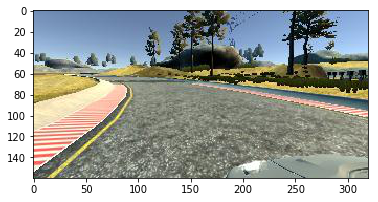

In [5]:
plt.imshow(read_image(data['left'][151]))
plt.show()

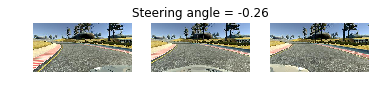

     left_image     center_image    right_image


In [6]:
#Visualize the images from left center and right cameras taking a random index
index = 151
left_image = read_image(data['left'][index])
center_image = read_image(data['center'][index])
right_image = read_image(data['right'][index])
plt.figure()
plt.subplot(1,3,1)
plt.imshow(left_image)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(center_image)
plt.axis('off')
plt.title('Steering angle = ' + str(np.round(data.steer[index] ,2)))
plt.subplot(1,3,3)
plt.imshow(right_image)
plt.axis('off')
plt.show()
print('     left_image     center_image    right_image')

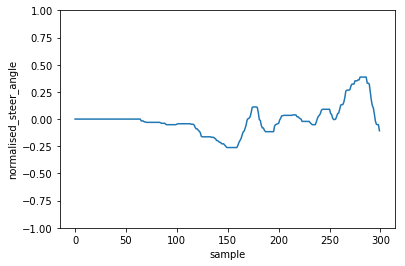

In [7]:
# Now let us try to visualize the entire steering data as a continuous signal, so that we can try and remove as much noise as possible
# here I would consider using a small smaple of size 300 initially
s_sample_size = 300
sample_steer_data = np.array(data.steer , dtype = np.float32)[0:300]
x_data = np.arange(len(sample_steer_data))
y_data = sample_steer_data
plt.plot(x_data,y_data)
plt.xlabel('sample')
plt.ylabel('normalised_steer_angle')
plt.ylim(-1,1)
plt.show()

In [8]:
# only consider data above certain speed
from sklearn import model_selection
data = data[data.speed>5]
#df_train, df_valid = model_selection.train_test_split(data, test_size=.2)
#print(len(df_train))
line_d = data.iloc[[2]].reset_index()

#### Step2 : Augmentation

In [9]:
# CLAHE for adaptive histogram equilization
def clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(6,6))    
    transform = clahe.apply(v)
    res= cv2.merge((h,s,transform))
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    return res

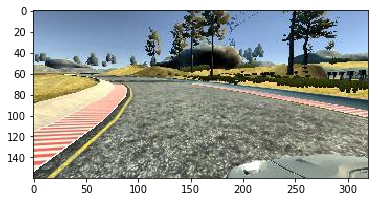

In [10]:
image = read_image(data['left'][151])
image = clahe(image)
plt.imshow(image)
plt.show()

In [11]:
# crop the image to right proportion and scale
# remove unwanted part of the image that is trees and resize to 66x200x3 for using nvidia model
#chopping 1/3 from top and 25 pixels from bottom
def cut_reshape_image(image):
    n_row,n_col,n_channel = 200,66,3
    shape = image.shape
    image = image[int(shape[0]/3):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(n_row,n_col), interpolation=cv2.INTER_AREA)
    return image    

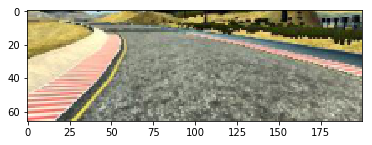

In [12]:
i1= cut_reshape_image(image)
plt.imshow(i1)
plt.show()

In [13]:
# Add left right camera images to train data with angle offset.
def lrimage(index):
    cameras = ['left', 'center', 'right']
    cameras_steering_correction = [.25, 0., -.25]
    camera = np.random.randint(len(cameras))
    image = cv2.imread(data[cameras[camera]][index])
    angle = data.steer[index]+cameras_steering_correction[camera]
    return image, angle

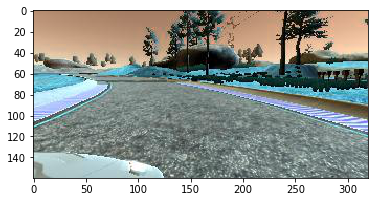

In [14]:
im1, angle = lrimage(151)
plt.imshow(im1)
plt.show()

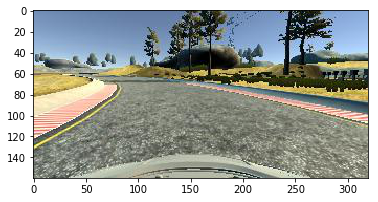

In [15]:
ind_num = 151
image_c = read_image(data['center'][ind_num].strip())
plt.imshow(image_c)
plt.show()

In [57]:
def shadow(image):
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return image

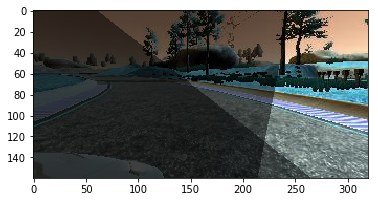

In [58]:
sh_img = shadow(im1)
plt.imshow(sh_img)
plt.show()

In [59]:
def gamma_crtn(image):
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

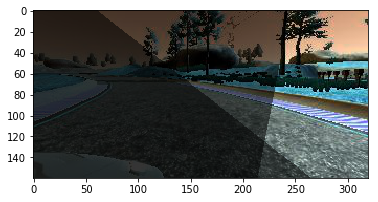

In [60]:
g_img = gamma_crtn(sh_img)
plt.imshow(g_img)
plt.show()

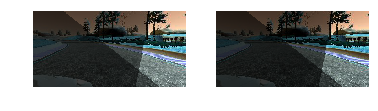

          nogamma              with gamma


In [61]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(sh_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(g_img)
plt.axis('off')
plt.show()
print('          nogamma              with gamma')



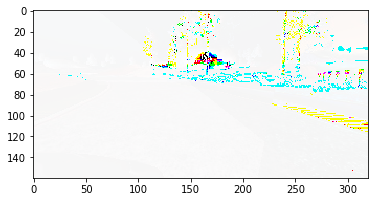

In [64]:
im_1=sh_img
im_2=g_img
im_3 = im_2 - im_1
plt.imshow(im_3)
plt.show()

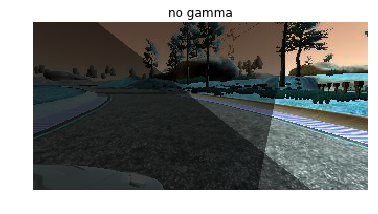

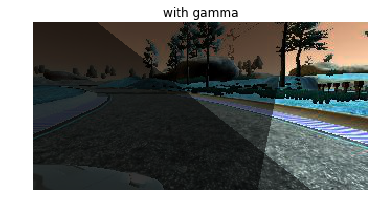

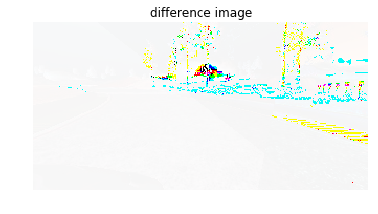

In [65]:
plt.figure()
#plt.subplot(1,3,1)
plt.imshow(sh_img)
plt.axis('off')
plt.title('no gamma')
plt.show()
#plt.subplot(1,3,2)
plt.imshow(g_img)
plt.axis('off')
plt.title('with gamma')
plt.show()
#plt.subplot(1,3,3)
plt.imshow(im_3)
plt.axis('off')
plt.title('difference image')
plt.show()
#print('     nogamma         with gamma   difference-image')



In [21]:
def shear_img(image, steering_angle, shear_range=200):
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering
    return image, steering_angle

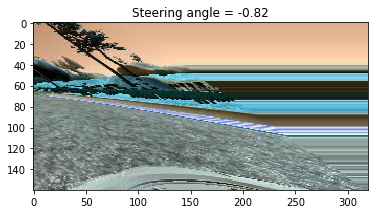

In [22]:
sh_img, sh_angle = shear_img(im1,angle)
plt.imshow(sh_img)
plt.title('Steering angle = ' + str(np.round(sh_angle ,2)))
plt.show()

In [23]:
# Horizontally flipping the images and negating the steering angles
def flip_index(index):
    cameras = ['left', 'center', 'right']
    cameras_steering_correction = [.25, 0., -.25]
    camera = np.random.randint(len(cameras))
    image = read_image(data[cameras[camera]][index])
    image = cv2.flip(image,1)
    steer = -data.steer(index)
    return image, steer

In [24]:
def pre_process_train(line):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_d['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_d['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_d['right'][0].strip()
        shift_ang = -.25
    steer = line_d['steer'][0] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = clahe(image)
    image = cut_reshape_image(image)
    image = shadow(image)
    image = np.array(image)
    pre = np.random.randint(10)
    if pre > 5:
        image = cv2.flip(image,1)
        steer = -steer
            
    return image, steer    
def preprocess_image_predict(line):
    path_file = line_d['center'][0].strip()
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cut_reshape_image(image)
    image = np.array(image)
    return image

In [25]:
new_row_size,new_col_size = 66,200
thres_prob = 1
def generator_train(data,batch_size=32):
    b_img = np.zeros((batch_size, new_row_size, new_col_size, 3))
    b_steer = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_d = data.iloc[[i_line]].reset_index()
            
            keep_prob = 0
            while keep_prob == 0:
                x,y = pre_process_train(line_d)
                un_prob = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>thres_prob:
                        keep_prob = 1
                else:
                    keep_prob = 1
            b_img[i_batch] = x
            b_steer[i_batch] = y
        yield b_img, b_steer
        
def generator_valid(data):
    while 1:
        for i_line in range(len(data)):
            line_d = data.iloc[[i_line]].reset_index()
            x = preprocess_image_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_d['steer'][0]
            y = np.array([[y]])
            yield x, y

        
val_gen = generator_valid(data)

#### Step : 4 CREATING THE NEURAL MODEL


In [26]:
input_shape = (66,200,3)
pool_size = (2,3)
filter_size= 3
model = Sequential()
model.add(MaxPooling2D(pool_size = pool_size, input_shape = input_shape))
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(Convolution2D(5, 5, 24, subsample=(4, 4), border_mode="same", name = 'conv0'))
model.add(ELU())
model.add(Convolution2D(5, 5, 36, subsample=(2, 2), border_mode="same", name = 'conv1'))
model.add(ELU())
model.add(Convolution2D(5, 5, 48, subsample=(2, 2), border_mode="same", name = 'conv2'))
model.add(ELU())
model.add(Convolution2D(3, 3, 64, subsample=(2, 2), border_mode="same", name = 'conv3'))
model.add(ELU())
model.add(Convolution2D(3, 3, 64, subsample=(2, 2), border_mode="same", name = 'conv4'))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(1164,  name = 'hidden1'))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(100, name = 'hidden2'))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(50, name = 'hidden3'))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(10))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(1, name = 'output'))
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")
model.summary()

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (5, 24), name="conv0", padding="same", strides=(4, 4))`
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (5, 36), name="conv1", padding="same", strides=(2, 2))`
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (5, 48), name="conv2", padding="same", strides=(2, 2))`
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (3, 64), name="conv3", padding="same", strides=(2, 2))`
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (3, 64), name="con

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 33, 66, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 33, 66, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 9, 17, 5)          1805      
_________________________________________________________________
elu_1 (ELU)                  (None, 9, 17, 5)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 5, 9, 5)           4505      
_________________________________________________________________
elu_2 (ELU)                  (None, 5, 9, 5)           0         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 5, 5)           6005      
__________

In [27]:
#function to save the model.
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [28]:
#function to keep trace of all the weights.
class WeightsLogger(Callback):
    def __init__(self, root_path):
        super(WeightsLogger, self).__init__()
        self.weights_root_path = os.path.join(out_dir, 'weights/')
        shutil.rmtree(self.weights_root_path, ignore_errors=True)
        os.makedirs(self.weights_root_path, exist_ok=True)
    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.weights_root_path, 'model_epoch_{}.h5'.format(epoch + 1)))

In [23]:
#final train
val_s=len(data)
pr_threshold = 1
batch_size = 256
i_best = 0
val_best = 1000
for i_pr in range(5):
    train_gen = generator_train(data,batch_size)
    history = model.fit_generator(train_gen, samples_per_epoch = 5120, nb_epoch = 1, validation_data = val_gen , nb_val_samples = val_s)
    with open(os.path.join(outdir, 'model.json'), 'w') as file:
        file.write(model.to_json())
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)


    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:9: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=5461, steps_per_epoch=5120, validation_data=<generator..., epochs=1)`


Epoch 1/1
5120/5120 [==============================] - 5882s - loss: 0.0082 - val_loss: 0.0067
Epoch 1/1
5120/5120 [==============================] - 7028s - loss: 0.0062 - val_loss: 0.0067
Epoch 1/1
5120/5120 [==============================] - 5844s - loss: 0.0061 - val_loss: 0.0067
Epoch 1/1
5120/5120 [==============================] - 5857s - loss: 0.0060 - val_loss: 0.0066
Epoch 1/1
5120/5120 [==============================] - 5852s - loss: 0.0060 - val_loss: 0.0067
Best model found at iteration # 3
Best Validation score : 0.0066
